In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
#tf.config.run_functions_eagerly(True)

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [2]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [3]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [5]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [6]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

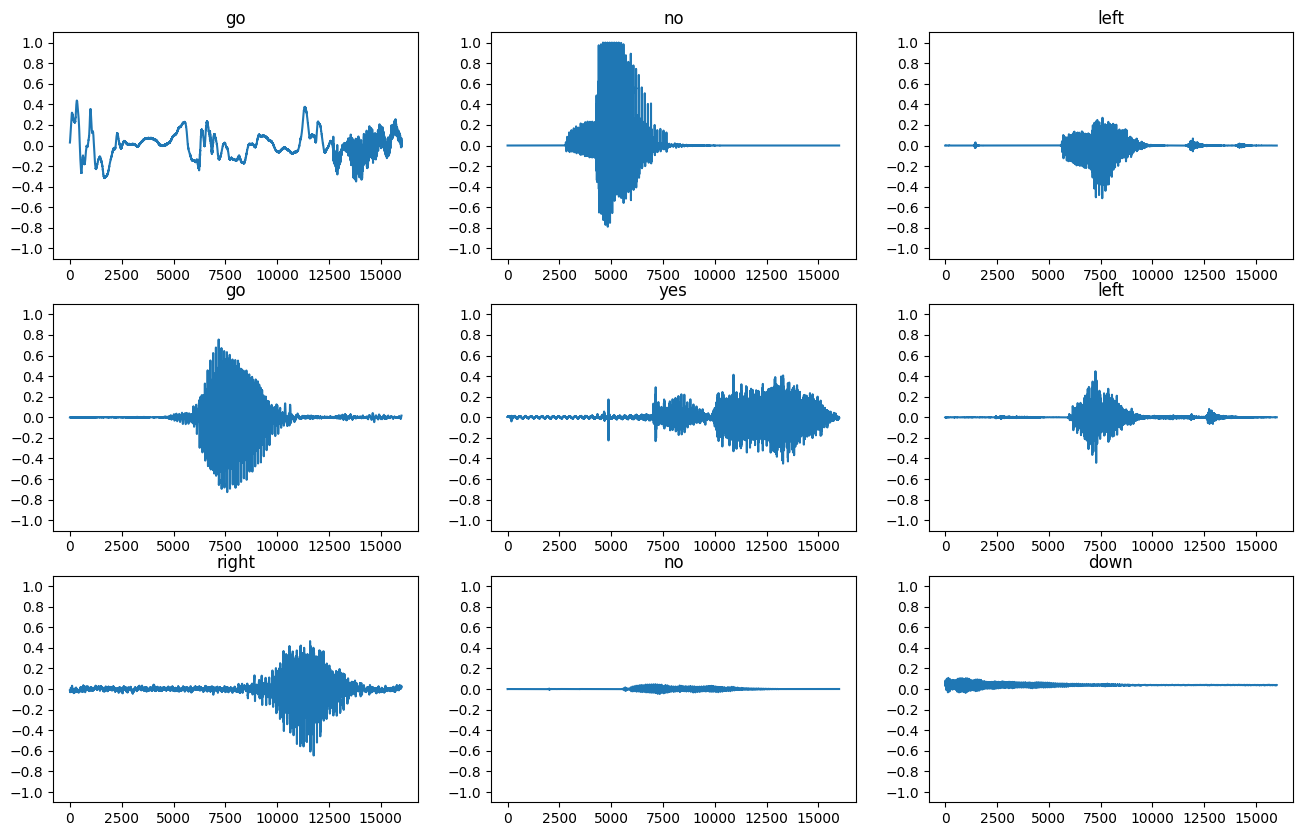

In [7]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [8]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

  def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [9]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [10]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

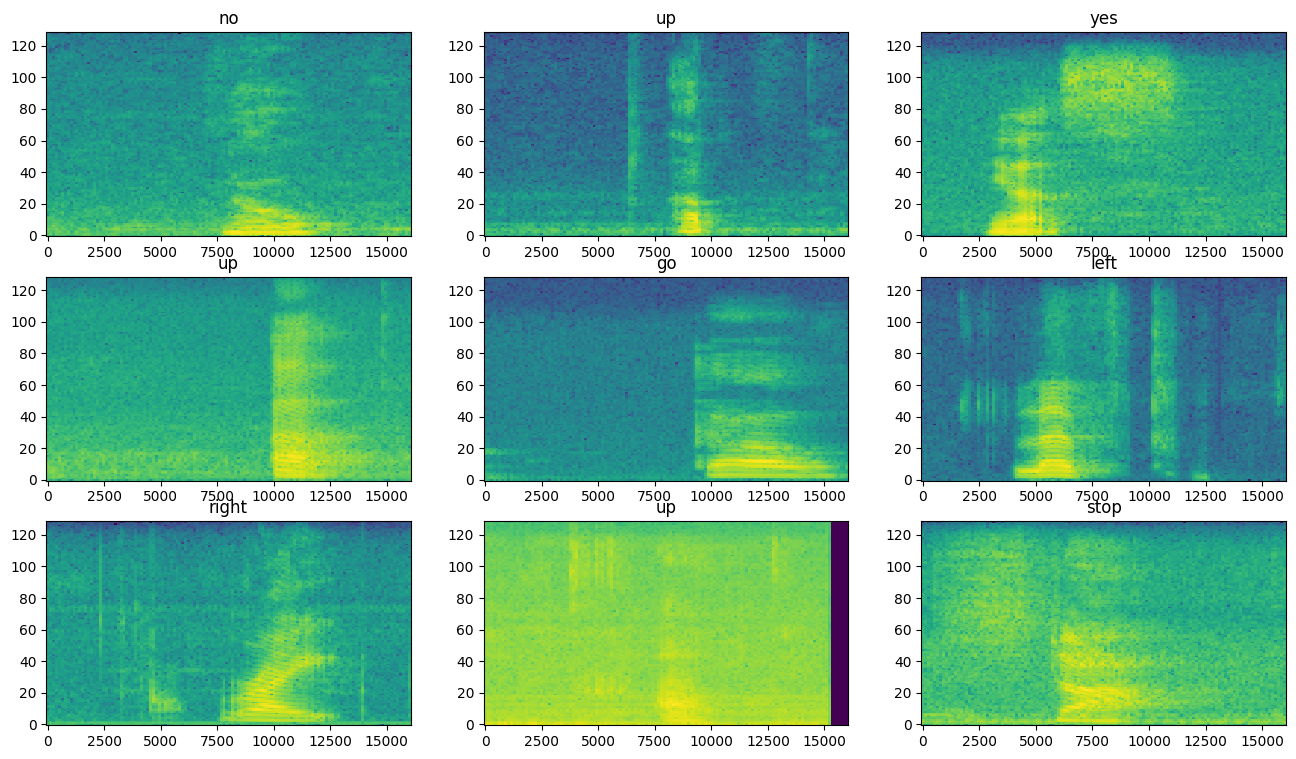

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [12]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import PReLU, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, Layer, AveragePooling1D, BatchNormalization, Reshape,Conv1D,LSTM, Dropout,Dense
from keras.regularizers import l1_l2
from tensorflow.keras.utils import register_keras_serializable
import keras.backend as K
# Set the seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Load the mini Speech Commands dataset
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

# List commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

# Function to load and preprocess data
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_spectrogram(waveform):
    # Zero-padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    output_ds = output_ds.map(
        lambda waveform, label: (get_spectrogram(waveform), label), 
        num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

# Label encoding as a lookup table in TensorFlow
class_names = tf.constant(commands)
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys=class_names, values=tf.constant(range(len(commands)), dtype=tf.int64)),
    default_value=-1)

# Apply label encoding in the preprocessing function
def encode_labels(waveform, label):
    label_id = table.lookup(label)
    return waveform, label_id

# Split data into training, validation, and test sets
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
train_files = filenames[:int(0.7 * num_samples)]
val_files = filenames[int(0.7 * num_samples): int(0.9 * num_samples)]
test_files = filenames[int(0.9 * num_samples):]

# Preprocess the data
train_ds = preprocess_dataset(train_files).map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = preprocess_dataset(val_files).map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = preprocess_dataset(test_files).map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and cache datasets
train_ds = train_ds.batch(64).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(64).cache().prefetch(tf.data.AUTOTUNE)

# Build the model
def build_model(input_shape):
    # model = models.Sequential([
    #     layers.Input(shape=input_shape),
    #     layers.Conv1D(32, 3, padding='same', activation=None),
    #     layers.PReLU(),
    #     layers.BatchNormalization(),
    #     layers.LSTM(32, return_sequences=True),
    #     layers.GlobalMaxPooling1D(),
    #     layers.Dense(64, activation='relu'),
    #     layers.Dense(len(commands), activation='softmax')
    # ])
    model = models.Sequential([
        BatchNormalization(input_shape=input_shape),

        Conv1D(32, kernel_size=3),
        PReLU(),
        BatchNormalization(),

        
        SpatialDropout1D(0.1),

        Conv1D(32, kernel_size=3),
        BatchNormalization(),
        PReLU(),
        
        SpatialDropout1D(0.1),

        LSTM(32, activation='tanh', recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),return_sequences=True),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dense(units=64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        
        Dropout(0.1),
        Dense(units=len(commands), activation='softmax')
    ])
    return model

# Example input shape, adjust based on your spectrogram shape
input_shape = (124, 129)  # This should match the output shape of your spectrogram function
model = build_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=20)


Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 124, 129)          516       
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 122, 32)           12416     
                                                                 
 p_re_lu (PReLU)             (None, 122, 32)           3904      
                                                                 
 batch_normalization_1 (Bat  (None, 122, 32)           128       
 chNormalization)                                                
                                                                 
 spatial_dropout1d (Spatial  (None, 122, 32)           0         
 Dropout1D)                                                 

In [13]:
model.evaluate(test_ds)[1]

13/13 [==============================] - 3s 205ms/step - loss: 0.4267 - accuracy: 0.9062


0.90625

Text(0, 0.5, 'Accuracy [%]')

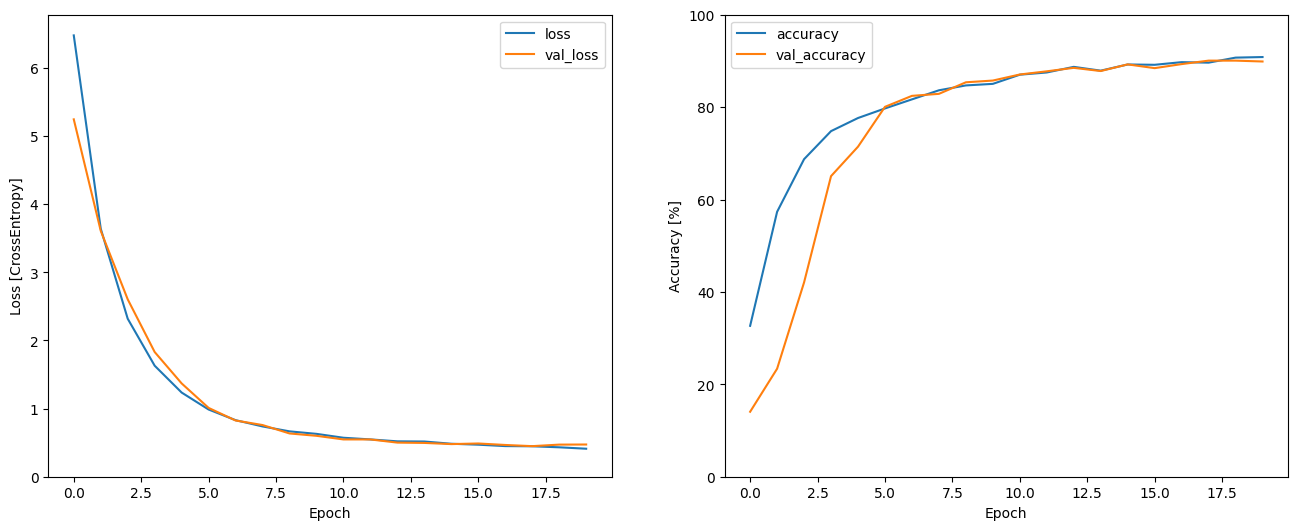

In [14]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [15]:
import numpy as np
import tensorflow as tf
import os
import pathlib

# Setting the seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Define the dataset path
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]

# Function to convert audio waveform to spectrogram
def get_spectrogram(waveform):
    padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram.numpy()

# Helper function to load and preprocess data
def preprocess_dataset(data_dir, commands):
    spectrograms = []
    labels = []
    for label in commands:
        filenames = tf.io.gfile.glob(str(data_dir / label / '*.wav'))
        for filename in filenames:
            audio_binary = tf.io.read_file(filename)
            audio, _ = tf.audio.decode_wav(audio_binary)
            waveform = tf.squeeze(audio, axis=-1)
            spectrogram = get_spectrogram(waveform)
            spectrograms.append(spectrogram)
            labels.append(label)
    return np.array(spectrograms), np.array(labels)

spectrograms, labels = preprocess_dataset(data_dir, commands)

# Encode labels as integers
label_indices = {label: i for i, label in enumerate(commands)}
label_array = np.array([label_indices[label] for label in labels])

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spectrograms, label_array, test_size=0.2, random_state=42, stratify=label_array)


In [16]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6400, 124, 129), (1600, 124, 129), (6400,), (1600,))

In [17]:
import gym
from gym import spaces
import numpy as np
import random
#tf.config.run_functions_eagerly(False)


print(tf.executing_eagerly())
class Plasticity(gym.Env):
    def __init__(self, dataset=(X_train,y_train), images_per_episode=1, random=True):
        super().__init__()
        self.action_space = gym.spaces.Discrete(len(commands))
        self.observation_space = spaces.Box(low=0, high=127, shape=(124,129), dtype=np.float32)
        self.images_per_episode = images_per_episode
        self.step_count = 0
        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):

        done = False
        reward = self.calculate_reward(action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()

        return obs
    
    def calculate_reward(self, action):
      if action == self.expected_action:
          reward = 1
      else:
          reward = 0

      return reward
    
    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x)-1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]


        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

True


In [18]:
import keras
from keras.backend import clear_session

In [19]:
# %%
env = Plasticity()

# %%
env.observation_space.sample()
env.observation_space.sample().shape

# %%
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Input
from tensorflow.keras.optimizers import Adam
tf.compat.v1.experimental.output_all_intermediates(True)

# %%
states = env.observation_space.shape
actions = env.action_space.n
print(states,actions)


(124, 129) 8


In [20]:
from keras.layers import PReLU, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, Layer, AveragePooling1D, BatchNormalization, Reshape,Conv1D,LSTM, Dropout
from keras.regularizers import l1_l2
from tensorflow.keras.utils import register_keras_serializable
import keras.backend as K
    
def build_model(states, actions):
    clear_session()
    model = Sequential([
        Reshape((124,129,),input_shape=(1,124,129)),
        
        BatchNormalization(),

        Conv1D(32, kernel_size=3),
        PReLU(),
        BatchNormalization(),

        
        SpatialDropout1D(0.1),

        Conv1D(32, kernel_size=3),
        BatchNormalization(),
        PReLU(),
        
        SpatialDropout1D(0.1),

        LSTM(32, activation='tanh', recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),return_sequences=True),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dense(units=64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        
        Dropout(0.1),
        Dense(units=len(commands), activation='linear')
    
    ])
    return model

In [21]:
# %%
import tensorflow as tf
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from keras import __version__
model = build_model(states, actions)
model.summary()


# %%
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=0.1)
    memory = SequentialMemory(limit=30000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-4)
    return dqn, policy

# %%
dqn, policy = build_agent(model, actions)
dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.0055,decay=1e-4), metrics=['mse'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 124, 129)          0         
                                                                 
 batch_normalization (Batch  (None, 124, 129)          516       
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 122, 32)           12416     
                                                                 
 p_re_lu (PReLU)             (None, 122, 32)           3904      
                                                                 
 batch_normalization_1 (Bat  (None, 122, 32)           128       
 chNormalization)                                                
                                                  

In [22]:

# %%
from rl.callbacks import Callback

class LossHistory(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][0])

class LossHistory2(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][1])

class RewardHistory(Callback):
    def on_train_begin(self, logs={}):
        self.rewards = []

    def on_episode_end(self, episode, logs={}):
        self.rewards.append(logs['episode_reward'])

class ExponentialDecayEpsilonCallback(Callback):
    def __init__(self, initial_epsilon, min_epsilon, decay_rate, decay_steps):
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.step_count = 0

    def on_step_end(self, step, logs={}):
        self.step_count += 1
        self.epsilon = self.min_epsilon + (self.epsilon - self.min_epsilon) * np.exp(-self.step_count / self.decay_steps)
        self.model.policy.eps = max(self.epsilon, self.min_epsilon)
        #print(f"Step: {self.step_count}, New Epsilon: {self.epsilon}")



initial_epsilon = 1.0  
min_epsilon = 0.0 
decay_rate = 0.0001     
decay_steps = 100000    
epsilon_decay_cb = ExponentialDecayEpsilonCallback(initial_epsilon, min_epsilon, decay_rate, decay_steps)


loss_history = LossHistory()
loss_history2 = LossHistory2()
reward_history = RewardHistory()


dqn.fit(env, nb_steps=11000, callbacks=[loss_history,loss_history2,reward_history,epsilon_decay_cb], verbose=1)
dqn.policy.eps = 0
dqn.fit(env, nb_steps=150, callbacks=[loss_history,loss_history2,reward_history], verbose=1)
dqn.fit(env, nb_steps=150, callbacks=[loss_history,loss_history2,reward_history], verbose=1)


Training for 11000 steps ...
Interval 1 (0 steps performed)


c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 2374s 237ms/step - reward: 0.7702
10000 episodes - episode_reward: 0.770 [0.000, 1.000] - loss: 0.080 - mse: 0.041 - mean_q: 0.851

Interval 2 (10000 steps performed)
 1000/10000 [==>...........................] - ETA: 45:11 - reward: 0.8850done, took 2675.329 seconds
Training for 150 steps ...
Interval 1 (0 steps performed)
  150/10000 [..............................] - ETA: 18:03 - reward: 0.8933done, took 16.553 seconds
Training for 150 steps ...
Interval 1 (0 steps performed)
  150/10000 [..............................] - ETA: 17:58 - reward: 0.8933done, took 16.468 seconds


In [23]:
features_array = np.concatenate((X_train,X_test))
label_array = np.concatenate((y_train,y_test))

In [24]:
# %%
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from rl.policy import GreedyQPolicy
dqn.policy = GreedyQPolicy()

def dqn_eval(dqn_agent,d):
    attempts, correct = 0, 0
    labels = d[1]
    eenv = Plasticity(dataset=d, random=False)
    thing = 1
    y_predFull = []
    y_trueest = []
    total_reward = 0
    try:
        while True:
            if thing == 1:
                obs = eenv.reset()
                thing = 0
            done = False
            while not done:

                obs_reshaped = np.reshape(obs, (1,) + obs.shape)

                q_values = dqn_agent.compute_q_values(obs_reshaped)
                #print(q_values)

                action = np.argmax(q_values)
                
                #print('action: ', action, " - ", labels[attempts])
                y_predFull.append(action)
                y_trueest.append(labels[attempts])

                obs, rew, done, _ = eenv.step(action)
                
                total_reward += rew
                if done:
                    attempts += 1
    except StopIteration:
        print()
        print('Validation done...','total reward=',total_reward+1)

        y_predFull = np.array(y_predFull)
        y_trueest = np.array(y_trueest)

        cm = confusion_matrix(y_trueest, y_predFull)
        print(y_predFull)
        print(y_trueest)

        print("Confusion Matrix:\n", cm)

        report = classification_report(y_trueest, y_predFull,digits=4)
        print("Classification Report:\n", report)

        report = classification_report(y_trueest, y_predFull,output_dict=True)

        correct = sum(y_predFull == y_trueest)
        attempts = len(y_trueest)
        accuracy = (float(correct) / attempts)
        print('Validation done...')
        print('Accuracy: {:.2f}%'.format(accuracy*100))

        F1 = report['macro avg']['f1-score']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']

        print("F1 Score: {:.2f}%".format(F1*100))
        print("Precision: {:.2f}%".format(precision*100))
        print("Recall: {:.2f}%".format(recall*100))

    y_predFull = []
    y_trueest = []
    return accuracy, F1, precision, recall

dqn_eval(dqn,d=(X_train,y_train))
print('***************************************************************************************')
dqn_eval(dqn,d=(X_test,y_test))
print('***************************************************************************************')

def dqn_eval2(d,split=10):
     
    n_splits = split
    mean_rewards_per_fold = []
    acc_per_fold = []
    f1_mean, p_mean, r_mean = [], [], []
    # Loop over each fold
    
    skf = StratifiedKFold(n_splits=n_splits)
    train, test = d
    for train_index, test_index in skf.split(train,test):
        xtr, xte = train[train_index],train[test_index]
        ytr, yte = test[train_index], test[test_index]

        test_env = Plasticity(dataset = (xte, yte),random=True)
        
        scores = dqn.test(test_env, nb_episodes=10, visualize=False, verbose=0)
        acc, f1, p, r = dqn_eval(dqn,d=(xte, yte))
        
        mean_reward = np.mean(scores.history['episode_reward'])
        mean_rewards_per_fold.append(mean_reward)
        acc_per_fold.append(acc)
        f1_mean.append(f1)
        r_mean.append(r)
        p_mean.append(p)
   
    overall_mean_reward = np.mean(mean_rewards_per_fold)

    #print(acc_per_fold)
    
    f1_avg, p_avg, r_avg = np.mean(f1_mean), np.mean(p_mean), np.mean(r_mean)
    #print(mean_rewards_per_fold)
    print(f"Overall Mean Reward across all folds: {overall_mean_reward * 100} %")
    acc_avg = np.mean(acc_per_fold)
    print(f"Overall Mean Accuracy across all folds: {acc_avg * 100} %")
    #print(f1_mean)
    print(f"Overall Mean F1 across all folds: {f1_avg * 100} %")
    #print(p_mean)
    print(f"Overall Mean Precision across all folds: {p_avg * 100} %")
    #print(r_mean)
    print(f"Overall Mean Recall across all folds: {r_avg * 100} %")
#dqn_eval2(d=(X_train,y_train))

dqn_eval2(d=(features_array,label_array))
#dqn_eval(dqn,d=(features_array,label_array))







Validation done... total reward= 5800
[5 5 1 ... 6 2 1]
[5 5 1 ... 6 2 1]
Confusion Matrix:
 [[706  66   0  10   0  12   5   1]
 [ 37 720   4  15   1   8  14   1]
 [  5  30 714   7   6  10  13  15]
 [ 20  53   2 708   4   5   5   3]
 [  9  35  17   3 726   5   3   2]
 [  8  24   2   0   2 756   5   2]
 [  5  44   6   0   1   7 735   2]
 [  5  24   9   9   5  12   1 735]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8881    0.8825    0.8853       800
           1     0.7229    0.9000    0.8018       800
           2     0.9469    0.8925    0.9189       800
           3     0.9415    0.8850    0.9124       800
           4     0.9745    0.9075    0.9398       800
           5     0.9276    0.9462    0.9368       799
           6     0.9411    0.9187    0.9298       800
           7     0.9658    0.9187    0.9417       800

    accuracy                         0.9064      6399
   macro avg     0.9136    0.9064    0.9083      6399
weigh

In [25]:
# %%

dqn_eval(dqn,d=(X_test,y_test))


Validation done... total reward= 1376
[7 5 2 ... 1 6 0]
[7 5 2 ... 3 6 0]
Confusion Matrix:
 [[168  18   0   7   1   2   2   2]
 [  9 171   1   7   2   4   5   0]
 [  2   5 170   7   1   3   2  10]
 [  5  20   3 166   0   2   2   2]
 [  2  10  14   2 166   4   2   0]
 [  1  11   0   1   0 177   9   1]
 [  3  16   3   0   0   1 177   0]
 [  0   6   5   3   1   4   0 181]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8842    0.8400    0.8615       200
           1     0.6654    0.8593    0.7500       199
           2     0.8673    0.8500    0.8586       200
           3     0.8601    0.8300    0.8448       200
           4     0.9708    0.8300    0.8949       200
           5     0.8985    0.8850    0.8917       200
           6     0.8894    0.8850    0.8872       200
           7     0.9235    0.9050    0.9141       200

    accuracy                         0.8605      1599
   macro avg     0.8699    0.8605    0.8629      1599
weigh

(0.8605378361475923,
 0.8628542322526788,
 0.8698980946317867,
 0.8605370603015075)

Testing for 30 episodes ...
Episode 1: reward: 0.000, steps: 1
Episode 2: reward: 1.000, steps: 1
Episode 3: reward: 1.000, steps: 1
Episode 4: reward: 1.000, steps: 1
Episode 5: reward: 0.000, steps: 1
Episode 6: reward: 1.000, steps: 1
Episode 7: reward: 1.000, steps: 1
Episode 8: reward: 1.000, steps: 1
Episode 9: reward: 1.000, steps: 1
Episode 10: reward: 1.000, steps: 1
Episode 11: reward: 1.000, steps: 1
Episode 12: reward: 1.000, steps: 1
Episode 13: reward: 1.000, steps: 1
Episode 14: reward: 1.000, steps: 1
Episode 15: reward: 1.000, steps: 1
Episode 16: reward: 1.000, steps: 1
Episode 17: reward: 1.000, steps: 1
Episode 18: reward: 0.000, steps: 1
Episode 19: reward: 1.000, steps: 1
Episode 20: reward: 1.000, steps: 1
Episode 21: reward: 1.000, steps: 1
Episode 22: reward: 1.000, steps: 1
Episode 23: reward: 1.000, steps: 1
Episode 24: reward: 1.000, steps: 1
Episode 25: reward: 1.000, steps: 1
Episode 26: reward: 1.000, steps: 1
Episode 27: reward: 1.000, steps: 1
Episode 2

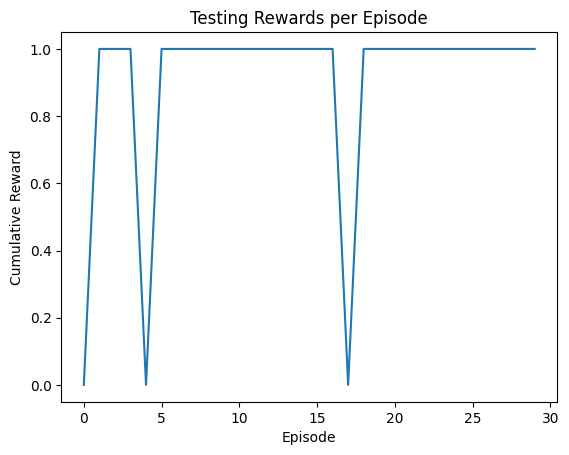

90.0 %
[5 5 1 ... 6 0 1] (8000,)

Validation done... total reward= 7177
[5 5 1 ... 1 6 0]
[5 5 1 ... 3 6 0]
Confusion Matrix:
 [[874  84   0  17   1  14   7   3]
 [ 46 891   5  22   3  12  19   1]
 [  7  35 884  14   7  13  15  25]
 [ 25  73   5 874   4   7   7   5]
 [ 11  45  31   5 892   9   5   2]
 [  9  35   2   1   2 934  14   3]
 [  8  60   9   0   1   8 912   2]
 [  5  30  14  12   6  16   1 916]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8873    0.8740    0.8806      1000
           1     0.7111    0.8919    0.7913       999
           2     0.9305    0.8840    0.9067      1000
           3     0.9249    0.8740    0.8987      1000
           4     0.9738    0.8920    0.9311      1000
           5     0.9220    0.9340    0.9280      1000
           6     0.9306    0.9120    0.9212      1000
           7     0.9572    0.9160    0.9361      1000

    accuracy                         0.8972      7999
   macro avg     0.9047   

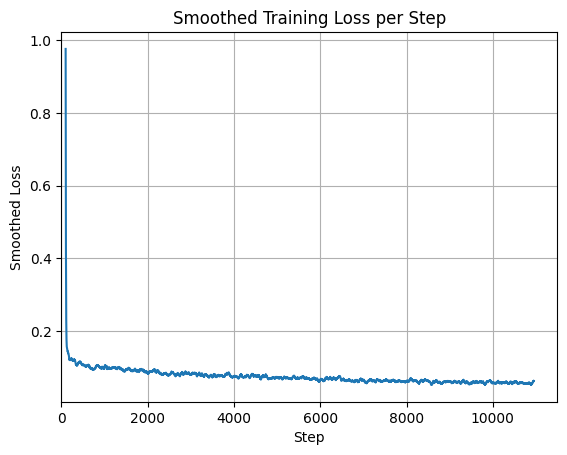

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.054160353, 0.05419108, 0.05434907, 0.054469403, 0.054570526, 0.054795247, 0.055105057, 0.055212308, 0.055183064, 0.05540081, 0.055619113, 0.05588197, 0.055867903, 0.05594279, 0.056100477, 0.056076016, 0.05611327, 0.056206644, 0.05619456, 0.05612284, 0.056018006, 0.05594303, 0.05599338, 0.056235995, 0.05663362, 0.056481984, 0.05650383, 0.056467555, 0.056563325, 0.056550726, 0.056695182, 0.056914315, 0.057027787, 0.0572626, 0.057657342, 0.05753064, 0.05764829, 0.057501506, 0.057580233, 0.0

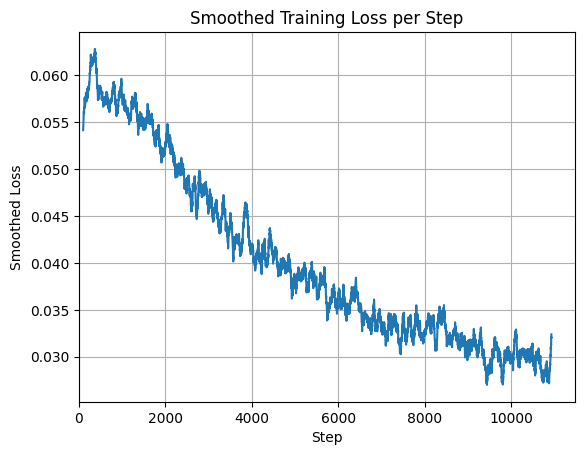

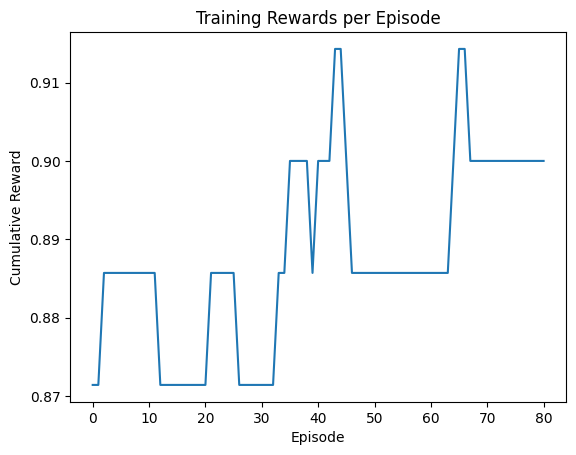

___________________________________________________________________________________________________________________________


In [26]:
# %%
scores = dqn.test(Plasticity(images_per_episode=1,random=True,dataset=(X_test,y_test)),nb_episodes=30, visualize=False, action_repetition=1, verbose=1)
print(np.mean(scores.history['episode_reward'])*100,'%')
plt.plot(scores.history['episode_reward'])
plt.title('Testing Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()
print(np.mean(scores.history['episode_reward'])*100,'%')
print(label_array,label_array.shape)

dqn_eval(dqn,d=(features_array,label_array))
def moving_average(data, window_size):
    return [np.mean(data[i:i+window_size]) for i in range(len(data) - window_size + 1)]
losses = loss_history.losses
losses2 = loss_history2.losses
smoothed_losses = moving_average(losses, window_size=50)
print(smoothed_losses)
plt.plot(smoothed_losses)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

smoothed_losses2 = moving_average(losses2, window_size=70)
print(smoothed_losses2)
plt.plot(smoothed_losses2)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

plt.plot(moving_average(reward_history.rewards, window_size=70))
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

print("___________________________________________________________________________________________________________________________")